In [1]:
import pandas as pd
import numpy as np
import time
import math
from scipy import stats

data = pd.read_excel('gasstationdata33.xlsx')
data.describe()

,Unnamed: 0,Customer,Arrival Time,Service time Fuel,Shop time,Service time payment
count,421.000000,421.000000,421,421.000000,421.000000,421.000000
mean,210.000000,210.000000,2024-02-01 14:05:36.790508032,289.990499,15.712589,45.660333
min,0.000000,0.000000,2024-02-01 06:00:06.644000,47.000000,0.000000,35.000000
25%,105.000000,105.000000,2024-02-01 09:55:41.463000064,179.000000,0.000000,41.000000
50%,210.000000,210.000000,2024-02-01 14:15:47.782000128,272.000000,0.000000,46.000000
75%,315.000000,315.000000,2024-02-01 17:57:28.728000,364.000000,0.000000,51.000000
max,420.000000,420.000000,2024-02-01 21:59:00.876000,925.000000,444.000000,55.000000
std,121.676484,121.676484,NaN,150.114036,44.506934,5.628251


In [2]:
arrivals = data["Arrival Time"]

fuel_time = data["Service time Fuel"]
shop_time = data["Shop time"]
payment_time = data["Service time payment"]

In [3]:
print(arrivals[0], arrivals[1], arrivals[2])

import pandas as pd

# Convert timestamps to datetime objects
arrivals_datetime = [arrival.to_pydatetime() for arrival in arrivals]

# make a datetime object for 2024-02-01 at 06:00:00
start_time = pd.to_datetime('2024-02-01 06:00:00')

print(arrivals_datetime[0])

# Calculate interarrival times in minutes
interarrival_times = [(arrivals_datetime[i] - arrivals_datetime[i-1]).total_seconds() / 60 if i != 0 else 
                      (arrivals_datetime[0] - start_time).total_seconds() / 60 for i in range(len(arrivals_datetime))]

print("Interarrival Times (in minutes):", interarrival_times)


2024-02-01 06:00:06.644000 2024-02-01 06:03:05.847000 2024-02-01 06:05:45.348000
2024-02-01 06:00:06.644000
Interarrival Times (in minutes): [0.11073333333333334, 2.9867166666666667, 2.65835, 1.7679666666666667, 7.943516666666667, 1.5156999999999998, 2.78795, 1.5053833333333333, 0.6180333333333333, 4.078516666666667, 1.29055, 0.09558333333333334, 0.0682, 0.69645, 0.1232, 0.91315, 1.7561666666666667, 0.13848333333333332, 2.5885166666666666, 2.4811833333333335, 1.5362833333333334, 0.03253333333333333, 5.831083333333334, 0.6334, 4.422333333333333, 8.3561, 2.656, 1.0834833333333334, 0.7053833333333334, 1.7998, 5.816083333333333, 0.7722333333333334, 0.46476666666666666, 0.29261666666666664, 7.2543, 5.738883333333334, 5.876783333333334, 2.8013166666666667, 8.801783333333333, 2.1713, 1.1534499999999999, 6.4944, 0.3862833333333333, 3.21845, 0.49198333333333333, 3.10005, 0.15475, 0.0559, 2.4139166666666667, 0.2659333333333333, 5.474716666666667, 2.483166666666667, 0.60505, 0.39885000000000004, 

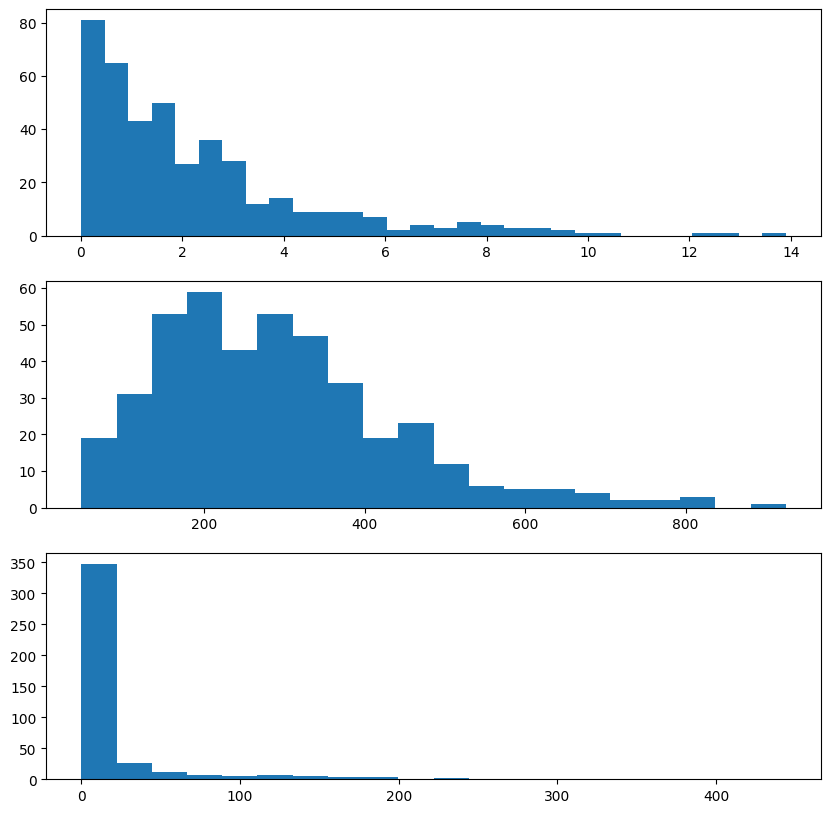

In [4]:
# a figure with 3 subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].hist(interarrival_times, bins=30)
axs[1].hist(fuel_time, bins=20)
axs[2].hist(shop_time, bins= math.floor(np.sqrt(len(shop_time))))
# axs[2].set_xlim(0, 200)

# show the plot
plt.show()

__Inter-arrival Time__

In [5]:
# exponential distribution
first_moment_arrival = np.mean(interarrival_times)
fitExponentialDist = stats.expon(scale = 1 / first_moment_arrival)
tst1 = stats.kstest(interarrival_times, fitExponentialDist.cdf)
print(tst1)

KstestResult(statistic=0.542689495666548, pvalue=1.1083594706178776e-116, statistic_location=0.8972666666666667, statistic_sign=-1)


In [6]:
# Gamma distribution
second_moment_arrival = np.mean([x**2 for x in interarrival_times])
estBeta = first_moment_arrival / (second_moment_arrival - first_moment_arrival**2)
estAlpha = first_moment_arrival * estBeta
fitGammaDist = stats.gamma (a = estAlpha, scale = 1/ estBeta)
tst2 = stats.kstest(interarrival_times, fitGammaDist.cdf)
print(tst2)

KstestResult(statistic=0.02441392860237468, pvalue=0.9580708179914103, statistic_location=3.2466333333333335, statistic_sign=1)


__Fuel Time__

In [7]:
# normal distribution
first_moment_fuel = np.mean(fuel_time)
estimated_std_fuel = np.std(fuel_time)
estimated_mean_fuel = first_moment_fuel

fitNormalDist_fuel = stats.norm(loc = estimated_mean_fuel, scale = estimated_std_fuel)
tst3 = stats.kstest(fuel_time, fitNormalDist_fuel.cdf)
print(tst3)

KstestResult(statistic=0.06756204744229954, pvalue=0.040874611008199224, statistic_location=341, statistic_sign=1)


In [8]:
# exponential distribution
fitExponentialDist_Fuel = stats.expon(scale = 1 / estimated_mean_fuel)
tst4 = stats.kstest(fuel_time, fitExponentialDist_Fuel.cdf)
print(tst4)

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=47, statistic_sign=-1)


In [9]:
# Gamma distribution
second_moment_fuel = np.mean([x**2 for x in fuel_time])
estBeta_fuel = first_moment_fuel / (second_moment_fuel - first_moment_fuel**2)
estAlpha_fuel = first_moment_fuel * estBeta_fuel
fitGammaDist_fuel = stats.gamma (a = estAlpha_fuel, scale = 1/ estBeta_fuel)
tst5 = stats.kstest(fuel_time, fitGammaDist_fuel.cdf)
print(tst5)

KstestResult(statistic=0.027474899868934588, pvalue=0.8995139987322393, statistic_location=291, statistic_sign=-1)


__Shop Time__

In [10]:
# exponential distribution
shop_time = shop_time[shop_time != 0]
first_moment_shop = np.mean(shop_time)
fitExponentialDist_shop = stats.expon(scale = 1 / first_moment_shop)
tst6 = stats.kstest(shop_time, fitExponentialDist_shop.cdf)
print(tst6)

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=1, statistic_sign=-1)


In [11]:
# Gamma distribution
second_moment_shop = np.mean([x**2 for x in shop_time])
estBeta_shop = first_moment_shop / (second_moment_shop - first_moment_shop**2)
estAlpha_shop = first_moment_shop * estBeta_shop
fitGammaDist_fuel = stats.gamma (a = estAlpha_shop, scale = 1/ estBeta_shop)
tst7 = stats.kstest(shop_time, fitGammaDist_fuel.cdf)
print(tst7)

KstestResult(statistic=0.06781579438961055, pvalue=0.754360742070755, statistic_location=24, statistic_sign=-1)


In [12]:
# Poisson distribution
fitPoissonDist_shop = stats.poisson(mu = first_moment_shop)
tst8 = stats.kstest(shop_time, fitPoissonDist_shop.cdf)
print(tst8)

KstestResult(statistic=0.5715869299999766, pvalue=1.3842769811232945e-29, statistic_location=52, statistic_sign=1)
